<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 7</strong>
</div>
<div style="text-align: center;">
<strong>RB-Galerkin for the heat equation</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

# 1 Imports and helper functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import time

# 2 RB-Galerkin for the heat equation

We consider the one-dimensional heat equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& u_t(t,x;\mu) = \mu u_{xx}(t,x;\mu), && t\in[0,T], \quad x\in[-1,1], \\
& u(t,-1;\mu) = u(t,1;\mu) = 0, && t\in[0,T], \\
& u(0,x;\mu) = u_0(x), && x\in[-1,1].
\end{align}

We will take $T=1$ and the following intial condition,

$$
u_0(x) = e^{-10x^2}.
$$

The reference solution $u(T,x;\mu)$ at time $T$ is computed on the grid with the matrix exponential using `expm`; see, e.g., <a href="https://en.wikipedia.org/wiki/Matrix_differential_equation" style="color: blue">this</a>.

**Note: In this problem, the parameter $\mu$ is the diffusion constant.**

We discretize space with

$$
x_j = -1 + jh, \quad h=2/(N_h+1), \quad 0\leq j\leq N_h+1.
$$

We have the following $N_h$ basis functions on $[-1,1]$. The $N_h$ degrees of freedom are the values at the $N_h$ interior grid points.

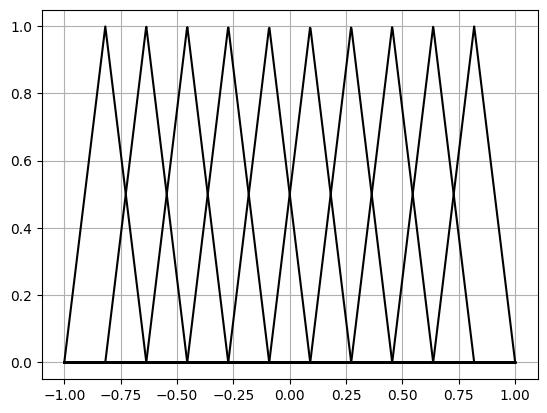

In [2]:
# Computation grid and basis functions:
N_h = 10
h = 2/(N_h + 1)
x_h = np.linspace(-1, 1, N_h + 2)
phi = lambda x: (1 - np.abs(x)) * (np.abs(x) <= 1)
Phi = lambda i, x: phi((x - x_h[i])/h)

# Plot basis functions on a finer grid:
N_eval = 1000
x_eval = np.linspace(-1, 1, N_eval + 1)
plt.figure()
for j in range(1, N_h + 1):
    plt.plot(x_eval, Phi(j, x_eval), 'k')
plt.grid();

## 2.1 Galerkin ODE system

We seek a finite element approximation of $u$

$$
u_h(t,x;\mu) = \sum_{j=1}^{N_h} u_h^j(t;\mu)\phi_j(x), \qquad u_h^j(t;\mu) = u_h(t,x_j;\mu),
$$

which verifies the Galerkin variational problem

$$
\int_{-1}^1 \partial_t u_h(t,x;\mu)\phi_i(x)dx = -\mu\int_{-1}^1 \partial_x u_h(t,x;\mu)\phi_i'(x)dx, \qquad 1\leq i\leq N_h.
$$

By substituting the expression for $u_h$, we obtain the following ODE system,

$$
\sum_{j=1}^{N_h} \partial_t u_h^j(t;\mu) \int_{-1}^1 \phi_i(x)\phi_j(x)dx = -\mu\sum_{j=1}^{N_h}u_h^j(t;\mu)\int_{-1}^1 \phi_i'(x)\phi_j'(x)dx, \qquad 1\leq i\leq N_h.
$$ 

We set

$$
(A_h(\mu))_{ij} = \mu\int_{-1}^1 \phi_i'(x)\phi_j'(x)dx, \qquad (M_h)_{ij} = \int_{-1}^1 \phi_i(x)\phi_j(x)dx.
$$

Then the $N_h\times N_h$ Galerkin ODE system reads

$$
M_h U_h'(t;\mu) = -A_h(\mu) U_h(t;\mu),
$$

with unknown $U_h(t;\mu) = (u_h^1(t;\mu),\ldots,u_h^{N_h}(t;\mu))^T$. Using **backward** Euler in time with time-step $k$ and $U_h(t_n=nk;\mu)\approx U^n(\mu)$, we get

$$
(M_h + k A_h(\mu)) U^{n+1}(\mu) = M_h U^n(\mu),
$$

where

$$
A_h(\mu) = \frac{\mu}{h}\mathrm{tridiag}(-1, 2, -1), \qquad M_h = \frac{h}{3}\mathrm{tridiag}(0.5, 2, 0.5).
$$

We recall that we can assemble the matrices and solve the Galerkin ODE system like this.

In [3]:
def assemble_matrices(N_h, mu):
    """
    Assemble the stiffness matrix A_h and mass matrix M_h for the Galerkin method.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    mu : float
        The diffusion constant.

    Returns
    -------
    A_h : scipy.sparse.csc_matrix
        The stiffness matrix of size (N_h, N_h).
    M_h : scipy.sparse.csc_matrix
        The mass matrix of size (N_h, N_h).
    """

    # Grid size:
    h = 2/(N_h + 1)

    # Stifness matrix:
    d1 = [-1] * (N_h - 1)
    d0 = [2] * N_h
    A_h = mu/h * diags([d1, d0, d1], [-1, 0, 1], format='csc')

    # Mass matrix:
    d1 = [0.5] * (N_h - 1)
    M_h = h/3 *  diags([d1, d0, d1], [-1, 0, 1], format='csc')
    
    return A_h, M_h

def solve_galerkin_ODE(k, N_h, T, u_0, mu):
    """
    Solve the Galerking ODE system with backward Euler.

    Parameters
    ----------
    k : float
        The time-step size.
    N_h : int
        The number of interior grid points.
    T : float
        The final time for the simulation.
    u_0 : function
        The function defining the initial condition.
    mu : float
        The diffusion constant.

    Returns
    -------
    np.ndarray
        The solution vector of size (N_h,) at the final time T.
    """

    # Grid:
    x_h = np.linspace(-1, 1, N_h + 2)

    # Construct the matrices:
    A_h, M_h = assemble_matrices(N_h, mu)

    # Evaluate the intial condition:
    U_h = u_0(x_h[1:-1])

    # Time-stepping with backward Euler:
    t = 0
    while t < T:
        U_h = spsolve(M_h + k * A_h, M_h @ U_h)
        t += k

    return U_h

### Validation

Time (online): 0.05932s
Error (L-inf): 2.31e-03


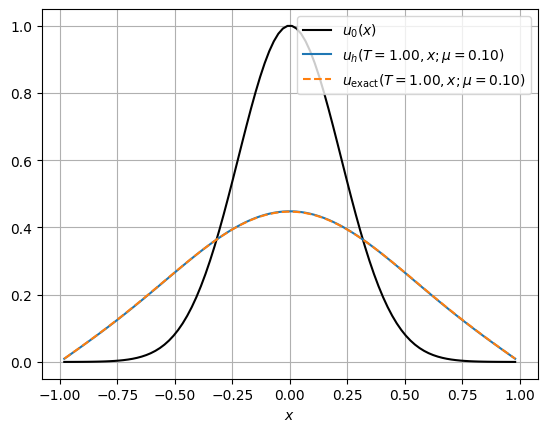

In [4]:
# PDE setup:
T = 1
mu = 1e-1
u_0 = lambda x: np.exp(-10*x**2)

# Grid setup:
N_h = 100
h = 2/(N_h + 1)
x_h = np.linspace(-1, 1, N_h + 2) # computation grid
N_eval = N_h
x_eval = x_h # evaluation grid

# Exact solution with matrix exponential:
def u_ex(t, mu):
    A_eval, M_eval = assemble_matrices(N_eval, mu)
    return expm(-t*spsolve(M_eval, A_eval).todense()) @ u_0(x_eval[1:-1])

# Solve Galerkin ODE system:
k = 1e-2
start = time.time() 
U_h = solve_galerkin_ODE(k, N_h, T, u_0, mu)
end = time.time()    
print(f'Time (online): {end-start:.5f}s')

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(1, N_h + 1), x_eval[1:-1])
u_h = Phi(I, XEVAL) @ U_h

# Compute the L-inf error:
error = np.max(np.abs(u_ex(T, mu) - u_h))/np.max(np.abs(u_ex(T, mu)))
print(f'Error (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval[1:-1], u_0(x_eval[1:-1]), '-k', label=r'$u_0(x)$')
plt.plot(x_eval[1:-1], u_h, '-', label=r'$u_h(T = %.2f, x; \mu = %.2f)$' % (T, mu))
plt.plot(x_eval[1:-1], u_ex(T, mu), '--', label=r'$u_\mathrm{exact}(T = %.2f, x; \mu = %.2f)$' % (T, mu))
plt.xlabel(r"$x$")
plt.grid()
plt.legend();

## 2.2 Snapshots

Next, we assemble the snapshot matrix at the final time $T$

$$
S = [U_h(T;\mu_1) | \ldots | U_h(T;\mu_n)] \in \R^{N_h\times n}.
$$

### Exercise

{exercise}
Complete the missing parts.

The $L^\infty$-error should be around $10^{-3}$.

In [5]:
def compute_snapshots(N_h, n, k, T, u_0, mu):
    """
    Compute a set of solution snapshots using the Galerkin method and backward Euler.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    n : int
        The number of parameter samples.
    k : float
        The time-step size.
    T : float
        The final time for the simulation.
    u_0 : function
        The function defining the initial condition.
    mu : np.ndarray
        The vector of parameter values.

    Returns
    -------
    S : np.ndarray
        A matrix of shape (N_h, n) where each column is a solution snapshot at the final time.
    """
    
    # Initialize the matrix:
    S = np.zeros((N_h, n))
    # Loop over the parameter values:
    for i in range(n):
        S[:, i] = solve_galerkin_ODE(k, N_h, T, u_0, mu[i])

    return S

### Validation

In [6]:
# Compute snapshots:
n = 50
mu_val = np.linspace(1e-3, 1, n)
start = time.time() 
S = compute_snapshots(N_h, n, k, T, u_0, mu_val)
end = time.time()
print(f'Time (offline): {end-start:.5f}s')

# Compute exact snapshots:
S_ex = np.zeros((N_h, n))
for i in range(n):
    S_ex[:, i] = u_ex(T, mu_val[i])

# Compute the L-inf error:
error = np.max(np.abs(S - S_ex))/np.max(np.abs(S_ex))
print(f'Error  (L-inf): {error:.2e}')

Time (offline): 1.33462s
Error  (L-inf): 1.45e-03


## 2.3 Reduced basis

Now, we compute the SVD of $S=U\Sigma V^T$ and set

$$
W = [U_1 | \ldots U_N] \in \R^{N_h\times N},
$$

where $N$ is chosen such that

$$
\frac{\sum_{j=1}^N\sigma_j^2}{\sum_{j=1}^r\sigma_j^2} \geq 1 - \epsilon^2.
$$

### Exercise

{exercise}
Complete the missing parts (same routine as before).

The singular values should decay to $10^{-16}$ and $N$ should be equal to $5$, corresponding to a singular value around $10^{-7}$. The functions $u_0$ and its projection should overlap perfectly.

In [7]:
def compute_reduced_basis(S, epsilon):
    """
    Computes a reduced basis using Singular Value Decomposition (SVD) by selecting the
    first N singular vectors that capture a desired amount of energy.

    Parameters
    ----------
    S : numpy.ndarray
        The input matrix for which the reduced basis is to be computed. It should be of shape (N_h, n). 
    epsilon : float
        The energy threshold (0 < epsilon < 1). It determines the fraction of the total energy 
        to be captured by the reduced basis.

    Returns
    -------
    W : numpy.ndarray
        The matrix of the first N singular vectors (reduced basis), with shape (N_h, N), where N is the 
        number of singular vectors selected.
    Sigma : numpy.ndarray
        The vector of singular values of S.
    N : int
        The number of singular vectors selected, corresponding to the desired energy threshold.
    
    Notes
    -----
    The function performs an SVD on the input matrix `S`, computes the cumulative energy captured 
    by the singular values, and selects the minimum number of singular vectors that capture at least 
    (1 - epsilon^2) of the total energy.
    """

    # SVD:
    U, Sigma, VT = np.linalg.svd(S, full_matrices=False)
    
    # Choose N from epsilon:
    N = np.searchsorted(np.cumsum(Sigma**2) / np.sum(Sigma**2), 1 - epsilon**2) + 1
    
    # Select the first N singular vectors:
    W = U[:, :N]

    return W, Sigma, N   

### Validation

5 3.8284759194842143e-07 6.306444927894594e-16


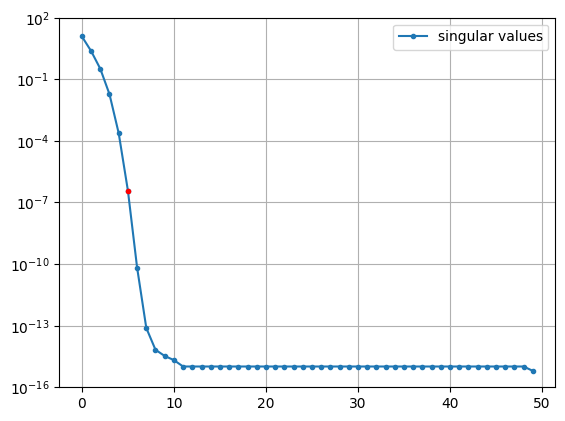

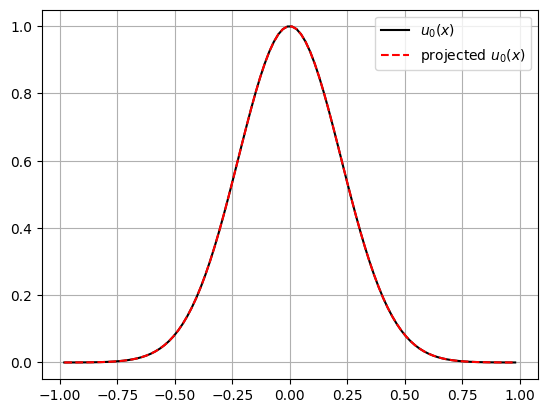

In [8]:
epsilon = 1e-6
W, Sigma, N = compute_reduced_basis(S, epsilon)
print(N, Sigma[N], Sigma[-1])

plt.figure()
plt.semilogy(Sigma, '.-', label="singular values")
plt.semilogy(N, Sigma[N], '.r')
plt.ylim(1e-16, 1e2)
plt.grid()
plt.legend();

v = W @ W.T @ u_0(x_h[1:-1])
plt.figure()
plt.plot(x_h[1:-1], u_0(x_h[1:-1]), '-k', label=r'$u_0(x)$')
plt.plot(x_h[1:-1], v, '--r', label=r'projected $u_0(x)$')
plt.grid()
plt.legend();

## 2.4 Reduced Galerkin ODE system

We finally compute a solution for a new $\mu$ via

$$
M_NU_N'(t;\mu) = -A_N(\mu)U_N(t;\mu),
$$

where

$$
M_N = W^TM_hW, \qquad A_N(\mu) = W^TA_h(\mu)W.
$$

### Exercise

{exercise}
Complete the missing parts.

The $L^\infty$-error should be at most around $10^{-2}$.

In [9]:
def solve_reduced_galerkin_ODE(k, N_h, T, u_0, mu):
    """
    Solves the reduced Galerkin ODE system using the reduced basis and backward Euler.

    Parameters
    ----------
    k : float
        The time-step size.
    N_h : int
        The number of interior grid points.
    T : float
        The final time for the simulation.
    u_0 : function
        The function defining the initial condition.
    mu : float
        The diffusion constant.

    Returns
    -------
    U_N : numpy.ndarray
        The solution of the ODE at the final time T in the reduced space, with shape (N,).
    
    Notes
    -----
    The time-stepping scheme uses an explicit method, solving for the solution at each time step using the reduced matrices (`M_N` and `A_N`).
    """
    
    # Grid:
    x_h = np.linspace(-1, 1, N_h + 2)

    # Construct the matrices:
    A_h, M_h = assemble_matrices(N_h,mu)

    # Construct the reduced matrices:
    A_N = W.T @ A_h @ W
    M_N = W.T @ M_h @ W

    # Reduced initial condition:
    U_N = W.T @ u_0(x_h[1:-1])

    # Time-stepping with backward Euler:
    t = 0
    while t < T:
        U_N = spsolve(M_N + k * A_N, M_N @ U_N)
        t += k
    
    return U_N

### Validation

C:\Users\ethan\AppData\Local\Temp\ipykernel_11048\898073227.py:44: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  U_N = spsolve(M_N + k * A_N, M_N @ U_N)


Time  (online): 0.03660s
Error  (L-inf): 7.81e-03


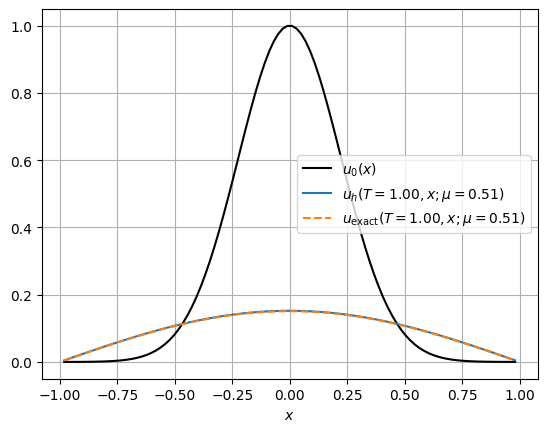

In [10]:
# Solve Galerkin ODE system:
mu_new = mu_val[0] + (mu_val[-1] - mu_val[0]) * np.random.rand()
start = time.time() 
U_N = solve_reduced_galerkin_ODE(k, N_h, T, u_0, mu_new)
end = time.time()     
print(f'Time  (online): {end-start:.5f}s')

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(1, N_h + 1), x_eval[1:-1])
u_h = Phi(I, XEVAL) @ W @ U_N

# Compute the L-inf error:
error = np.max(np.abs(u_ex(T, mu_new) - u_h))/np.max(np.abs(u_ex(T, mu_new)))
print(f'Error  (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval[1:-1], u_0(x_eval[1:-1]), '-k', label=r'$u_0(x)$')
plt.plot(x_eval[1:-1], u_h, '-', label=r'$u_h(T = %.2f, x; \mu = %.2f)$' % (T, mu_new))
plt.plot(x_eval[1:-1], u_ex(T, mu_new), '--', label=r'$u_\mathrm{exact}(T = %.2f, x; \mu = %.2f)$' % (T, mu_new))
plt.xlabel(r"$x$")
plt.grid()
plt.legend();